In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules 
from sklearn.model_selection import train_test_split   #- partition train/test split 
from sklearn.tree import DecisionTreeClassifier        #- create a decison tree 
from sklearn.ensemble import ExtraTreesClassifier      #- random trees 
from sklearn.ensemble import RandomForestClassifier    #- random forest classifier 
from sklearn.ensemble import GradientBoostingClassifier #- GBM classfier 

# -- we need these to make our pipelines 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

# -- we need these to evaluate our models 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

# -- categorical encoders -- 
import category_encoders as ce 


# -- need this to render charts in notebook -- 
%matplotlib inline


In [2]:
df = pd.read_csv("./data/new_subscribers.csv")
df.head()

,total_lifetime_value,credit_score,shipping_amt,promo_discount,ip_address,avs_code,email_domain,user_agent,billing_postal,phone_id,...,phone_plan,accessory_count,event_timestamp,transaction_id,customer_name,billing_address,billing_state,email_name,phone_number,is_fraud
0,5899.0,647.0,71.0,267.0,6.58.107.44,Q,harrington-barrett.com,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,34630.0,130.0,...,Just Kids,4.0,2020-04-28 02:58:00,9.379067e+09,Stephanie Fletcher,89142 Smith Light Fake St.,VA,haley41,(220)631-5381,0
1,4882.0,582.0,72.0,154.0,50.60.19.244,A,juarez-howard.com,Mozilla/5.0 (iPad; CPU iPad OS 4_2_1 like Mac ...,34293.0,140.0,...,Do More Unlimited,4.0,2020-05-08 17:54:53,4.271059e+09,Rita Conley,8045 Taylor Camp Fake St.,UT,jennifergarcia,+1-636-156-6620x3320,0
2,4871.0,624.0,55.0,253.0,195.253.71.163,C,butler.net,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_5_6) A...,32424.0,241.0,...,Just Kids,6.0,2020-01-01 21:34:21,2.856708e+09,Sophia Goodman,27185 Santos Common Fake St.,CO,edward79,+1-254-407-6887x778,0
3,6404.0,599.0,63.0,258.0,89.103.126.109,F,casey-thomas.com,Mozilla/5.0 (Windows; U; Windows NT 5.1) Apple...,32457.0,132.0,...,Just Kids,6.0,2019-12-13 07:21:42,5.797872e+09,Linda Ray,35490 Xavier Knolls Fake St.,ID,derekramirez,001-651-607-4678x1641,0
4,4530.0,572.0,56.0,251.0,45.247.92.14,F,meyer-flores.com,Mozilla/5.0 (iPod; U; CPU iPhone OS 4_3 like M...,32453.0,211.0,...,Just Kids,4.0,2019-10-11 18:54:24,9.983474e+09,Angela Davis,9478 Byrd Shore Fake St.,IN,rperez,4748914665,0


In [37]:
phones = pd.read_csv("phones.csv").rename(columns={"product_id":"phone"})
phones.head()

,phone,product_name,product_mfg
0,0,"Samsung Galaxy S9, 64GB, Lilac Purple - Fully ...",Samsung
1,1,Samsung Galaxy A71 SM-A715F/DS 4G LTE 128GB + ...,Samsung
2,2,"Apple iPhone 8 Plus, GSM Unlocked, 64GB - Spac...",Apple
3,3,"Motorola Moto G7 (64GB, 4GB RAM) Dual SIM 6.2""...",Motorola
4,4,OnePlus 8 Pro Ultramarine Blue 12GB+256GB with...,OnePlus


In [3]:
df.columns = ( df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
)
print(df.columns)

Index(['total_lifetime_value', 'credit_score', 'shipping_amt',
       'promo_discount', 'ip_address', 'avs_code', 'email_domain',
       'user_agent', 'billing_postal', 'phone_id', 'phone_count',
       'phone_trade_in', 'phone_protection', 'contract_term', 'phone_plan',
       'accessory_count', 'event_timestamp', 'transaction_id', 'customer_name',
       'billing_address', 'billing_state', 'email_name', 'phone_number',
       'is_fraud'],
      dtype='object')


In [19]:
df_20k = df.sample(20000)
df_20k.shape

(20000, 24)

In [20]:
def df_profile(df, target):
    
    df = df.copy()
    
    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]
    
    categorical_features = [ c for c in df.select_dtypes(include = np.object).columns ]
   
    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)
    # -- part 2 
    df_stats['feature_type'] = "UNKOWN"
    df_stats.loc[df_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    # df_stats.loc[df_stats["dtype"] == "float64", 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"] == target, 'feature_type'] = "TARGET"
    
    
    # -- part 3 
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats["nunique_pct"] > 0.7,'feature_warning' ] = "EXCLUDE, GT 70% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    #if null_pct > 0.2 then feature_warning = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
    #df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
 
    return df_stats

df_profile(df, "is_fraud")

,feature_name,dtype,count,nunique,mean,min,max,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,is_fraud,int64,100000,2,0.05281,0,1,0,100000,0.00000,0.00002,TARGET,NO WARNING
1,transaction_id,float64,99954,99954,5.5041e+09,1.00005e+09,9.99999e+09,46,99954,0.00046,0.99954,NUMERIC,"EXCLUDE, GT 70% UNIQUE"
2,accessory_count,float64,99967,10,5.11296,1,10,33,99967,0.00033,0.00010,NUMERIC,NO WARNING
3,phone_count,float64,100000,6,3.35578,-1,5,0,100000,0.00000,0.00006,NUMERIC,NO WARNING
4,phone_id,float64,99954,273,166.992,1,305,46,99954,0.00046,0.00273,NUMERIC,NO WARNING
5,billing_postal,float64,99954,2002,33454.7,32005,34996,46,99954,0.00046,0.02002,NUMERIC,NO WARNING
6,total_lifetime_value,float64,100000,5716,5033.48,-1,9999,0,100000,0.00000,0.05716,NUMERIC,NO WARNING
7,shipping_amt,float64,100000,87,56.5814,-1,99,0,100000,0.00000,0.00087,NUMERIC,NO WARNING
8,promo_discount,float64,99953,384,261.979,50,499,47,99953,0.00047,0.00384,NUMERIC,NO WARNING
9,credit_score,float64,100000,361,593.251,-1,799,0,100000,0.00000,0.00361,NUMERIC,NO WARNING


In [21]:
# 1. Split features into categorical and numeric 
target = 'is_fraud'

numeric_features = ['total_lifetime_value',
                    "credit_score", 
                    "shipping_amt", 
                    "phone_count"]

categorical_features = ["email_domain"] 

feature_names = numeric_features + categorical_features

## i'm taking a simplistic appraoch and filling in missing values by hand first 

In [22]:
df.isnull().sum(axis = 0)
# 2. deal with nulls using fillna 
df[numeric_features]     = df[numeric_features].fillna(-1)
df[categorical_features] = df[categorical_features].astype('str').fillna('missing')
df.isnull().sum(axis = 0)

total_lifetime_value     0
credit_score             0
shipping_amt             0
promo_discount          47
ip_address              45
avs_code                41
email_domain             0
user_agent              51
billing_postal          46
phone_id                46
phone_count              0
phone_trade_in          48
phone_protection        38
contract_term           31
phone_plan              39
accessory_count         33
event_timestamp         44
transaction_id          46
customer_name           40
billing_address         39
billing_state           62
email_name              36
phone_number            40
is_fraud                 0
dtype: int64

In [23]:
## Convert income to a 0 / 1 
#df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['is_fraud'].value_counts(normalize=True)

0    0.94719
1    0.05281
Name: is_fraud, dtype: float64

In [24]:
train, test = train_test_split(df,test_size=0.30)
print("train pct: {:2.2%}".format(train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df.shape[0]))

train pct: 70.00%
test  pct: 30.00%


In [25]:
target = 'is_fraud'

numeric_features = ['total_lifetime_value',
                    "credit_score", 
                    "shipping_amt", 
                    "phone_count"]

categorical_features = ["email_domain", "avs_code"] 

In [27]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

decision_tree = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(max_depth = 10,
                                          min_samples_leaf = 2, 
                                          criterion = 'gini',
                                          random_state=42))
])

decision_tree.fit(train[ categorical_features + numeric_features ], train[target])
    

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   16.5s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   18.0s finished


Best parameter (CV auc=0.910):
{'classifier__n_estimators': 30, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.15}


--- Training & Test Performance ---
(Training):
Accuracy 0.965
AUC.     0.923
(Test):
Accuracy 0.966
AUC.     0.919


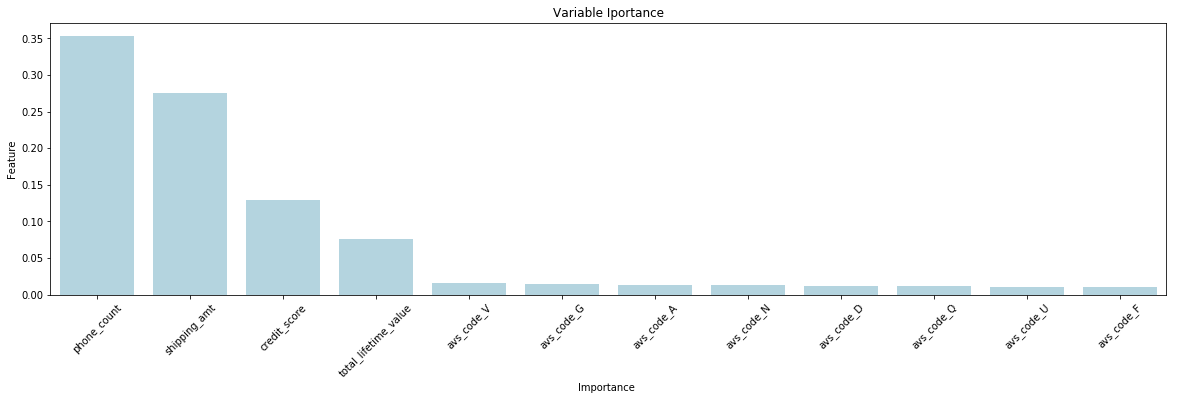

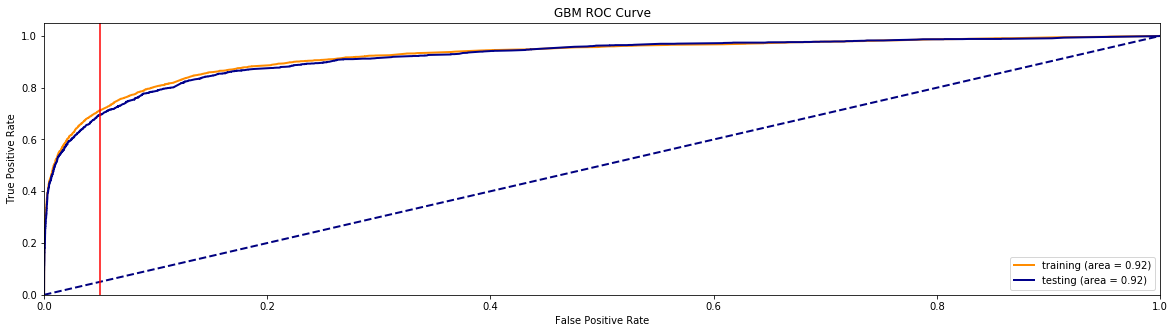

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.43       0.53
1  0.02  0.55       0.30
2  0.03  0.60       0.20
3  0.04  0.64       0.15
4  0.05  0.68       0.13




In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

def model_gbm_fit(param_grid):
    
    # -- define pipeline --
    categorical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot',  OneHotEncoder(handle_unknown='ignore', ))  
    ])

    numerical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('cat', categorical_pipe, categorical_features),
        ('num', numerical_pipe, numeric_features)
        ])

    model_pipeline = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', GradientBoostingClassifier())
    ])
    
    
    # -- setup grid search -- 
    gbm_model = RandomizedSearchCV(model_pipeline, param_grid,n_iter=3, n_jobs=-1, verbose=3, cv=3, scoring="roc_auc", refit=True)
    # -- fit grid search --
    gbm_model.fit(train[ categorical_features + numeric_features ], train[target])
    # -- print results -- 
    print("Best parameter (CV auc=%0.3f):" % gbm_model.best_score_)
    print(gbm_model.best_params_)
    print("\n")
    
    # -- assess best model, notice refit=True -- 
    train['.pred'] = gbm_model.predict(train[numeric_features + categorical_features])
    train['.prob'] = gbm_model.predict_proba(train[numeric_features + categorical_features])[:,1]
    train_probabilites = gbm_model.predict_proba(train[numeric_features + categorical_features])
    train_fpr, train_tpr, train_thr= roc_curve(train[target], train_probabilites[:,1])
    
    print("--- Training & Test Performance ---")
    print("(Training):")
    print("Accuracy %0.3f" % accuracy_score(train[target], train['.pred']))
    print("AUC.     %0.3f" % auc(train_fpr,train_tpr))
    
    test['.pred'] = gbm_model.predict(test[numeric_features + categorical_features])
    test['.prob'] = gbm_model.predict_proba(test[numeric_features + categorical_features])[:,1]
    test_probabilites = gbm_model.predict_proba(test[numeric_features + categorical_features])
    test_fpr, test_tpr, test_thr = roc_curve(test[target], test_probabilites[:,1])
    
    print("(Test):")
    print("Accuracy %0.3f" % accuracy_score(test[target], test['.pred']))
    print("AUC.     %0.3f" % auc(test_fpr,test_tpr))
    
    importance =  gbm_model.best_estimator_.named_steps["classifier"].feature_importances_
    # -- gets the feature names 
    categorical_pipe.fit_transform(train[categorical_features])
    transformed_categorical = categorical_pipe['onehot'].get_feature_names(categorical_features).tolist()

    # -- creates one list of all the feature names. 
    feature_names =  transformed_categorical + numeric_features
    
    
    feature_imp ={}
    for i,v in enumerate(importance):
        feature_imp[feature_names[i]] = v
        
     # make the dictionary a data frame 
    feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                         columns=['importance'])

    # -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
    feature_imp = (feature_imp
                   .reset_index()
                   .rename(columns={'index':'feature'})
                   .sort_values('importance',ascending=False)
                   .query('importance > 0.01'))

    # -- plot that 
    plt.figure(figsize=(20,5))
    sns.barplot(y="importance", x="feature", data=feature_imp, color="lightblue")
    plt.title( 'Variable Iportance')
    plt.ylabel('Feature')
    plt.xlabel('Importance ')
    plt.xticks(rotation=45)
    plt.show()
    
    # -- make ROC charts 
    #- 5. FPR from 1 - 5% 
    model_stat = pd.concat([
        pd.DataFrame(test_fpr).rename(columns={0:'fpr'}),
        pd.DataFrame(test_tpr).rename(columns={0:'tpr'}),
        pd.DataFrame(test_thr).rename(columns={0:'threshold'})
        ],axis=1
        ).round(decimals=2)
   
    # - just get 1% FPR increments o
    m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()]    
    
    #- 3. get auc and threshold for train and test 
    train_auc = auc( train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    #- 6. plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=2, label='training (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, color='darkblue',
             lw=2, label='testing (area = %0.2f)' % test_auc)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.axvline(x= 0.05,  color='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( 'GBM ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print("--- TEST score thresholds ---")
    print(m.loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.05)].reset_index(drop=True))
    print("\n")
    
    
    return gbm_model, train , test  

param_grid = {
    'classifier__learning_rate':[0.15, 0.2],
            'classifier__n_estimators': [20,30],
            'classifier__max_depth': [5, 10],
            'classifier__min_samples_leaf': [2,4]
    }

gbm, train, test  = model_gbm_fit(param_grid)


In [11]:
train.head()

,total_lifetime_value,credit_score,shipping_amt,promo_discount,ip_address,avs_code,email_domain,user_agent,billing_postal,phone_id,...,event_timestamp,transaction_id,customer_name,billing_address,billing_state,email_name,phone_number,is_fraud,.pred,.prob
53103,5772.0,607.0,76.0,271.0,157.132.71.51,A,caldwell.net,Mozilla/5.0 (iPad; CPU iPad OS 5_1_1 like Mac ...,33948.0,174.0,...,2019-07-17 19:59:09,9.905737e+09,Chelsey King,895 Fletcher Roads Fake St.,GA,pooleamanda,(676)681-0778,0,0,0.026922
57182,6748.0,644.0,73.0,260.0,139.32.142.195,N,yoder-duffy.info,Mozilla/5.0 (iPod; U; CPU iPhone OS 4_0 like M...,32437.0,121.0,...,2020-02-18 20:14:04,6.630286e+09,Jamie Caldwell,135 Brown Tunnel Fake St.,ME,janice68,(629)177-3875,0,0,0.007424
61840,5294.0,593.0,63.0,210.0,220.159.247.243,Q,hoover-nguyen.info,Mozilla/5.0 (X11; Linux i686) AppleWebKit/535....,32219.0,182.0,...,2020-05-08 16:08:32,3.573380e+09,Jessica Solomon,125 Christina Point Fake St.,WV,linda90,2055677451,0,0,0.006313
74865,4923.0,570.0,60.0,270.0,38.170.2.159,D,zimmerman.com,Opera/8.95.(Windows NT 5.01; tk-TM) Presto/2.9...,33094.0,186.0,...,2019-09-30 16:23:28,4.209426e+09,Joseph Simmons,4320 Patel Forest Fake St.,ID,umatthews,825.117.0216,0,0,0.139768
94992,4177.0,535.0,52.0,207.0,143.216.5.202,Q,ibarra.com,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,32244.0,214.0,...,2019-09-19 01:46:28,6.100178e+09,Eric Wilcox,970 Angela Station Fake St.,NC,jonathannguyen,4651135783,0,0,0.006366


In [29]:
from sklearn.tree import DecisionTreeRegressor 
# -- this is your pipeline based model -- 
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

dt_explainer = Pipeline([
    ('preprocess', preprocessing),
    ('explainer', DecisionTreeRegressor(max_depth = 5,
                                          min_samples_leaf = 2,
                                          random_state=42))
])

dt_explainer = dt_explainer.fit(train[categorical_features + numeric_features], train[".prob"])
dt_explainer

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [30]:
# -- get the feature names from the transform, remember we've now made a number of new columns by doing one-hot-encoding --
categorical_pipe.fit_transform(train[categorical_features])
transformed_categorical = categorical_pipe['onehot'].get_feature_names(categorical_features).tolist()

# -- creates one list of all the feature names. 
feature_names =  transformed_categorical + numeric_features
feature_names

['email_domain_acosta-walker.org',
 'email_domain_acosta.com',
 'email_domain_acosta.net',
 'email_domain_acosta.org',
 'email_domain_adams-carson.biz',
 'email_domain_adams-fitzpatrick.com',
 'email_domain_adams-gardner.com',
 'email_domain_adams-guzman.org',
 'email_domain_adams-marquez.org',
 'email_domain_adams-martinez.com',
 'email_domain_adams-patterson.com',
 'email_domain_adams-rasmussen.com',
 'email_domain_adams.biz',
 'email_domain_adams.com',
 'email_domain_adams.info',
 'email_domain_adams.org',
 'email_domain_adkins-miller.com',
 'email_domain_adkins.com',
 'email_domain_adkins.net',
 'email_domain_aguilar-anderson.biz',
 'email_domain_aguilar-moss.com',
 'email_domain_aguilar-ruiz.com',
 'email_domain_aguilar.com',
 'email_domain_aguirre-griffith.com',
 'email_domain_aguirre.com',
 'email_domain_alexander-davies.com',
 'email_domain_alexander-hutchinson.net',
 'email_domain_alexander-williams.com',
 'email_domain_alexander.com',
 'email_domain_alexander.info',
 'email_d

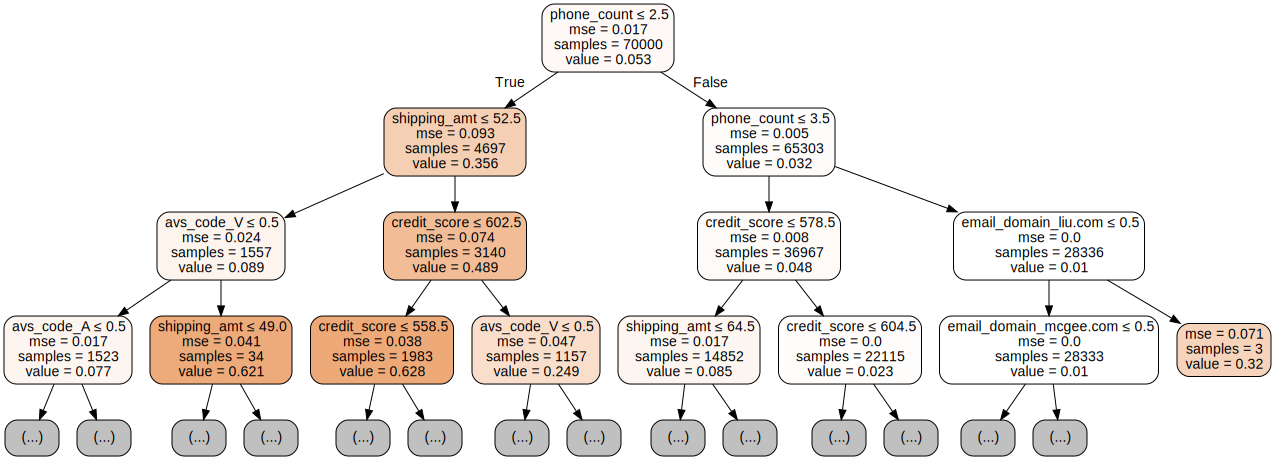

In [31]:
# -- chart of tree 
import graphviz 
from sklearn.tree import export_text                   #- export tree as text rules 
from sklearn import tree

dot_data = tree.export_graphviz(dt_explainer['explainer'], 
                                out_file=None,
            feature_names = feature_names,
            max_depth = 3,
            filled=True, 
            rounded=True,  
            special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [32]:
# -- Text based Rules for your Tree 
r = export_text(dt_explainer['explainer'], 
                feature_names= feature_names)
print(r)

|--- phone_count <= 2.50
|   |--- shipping_amt <= 52.50
|   |   |--- avs_code_V <= 0.50
|   |   |   |--- avs_code_A <= 0.50
|   |   |   |   |--- avs_code_F <= 0.50
|   |   |   |   |   |--- value: [0.06]
|   |   |   |   |--- avs_code_F >  0.50
|   |   |   |   |   |--- value: [0.70]
|   |   |   |--- avs_code_A >  0.50
|   |   |   |   |--- shipping_amt <= 40.00
|   |   |   |   |   |--- value: [0.33]
|   |   |   |   |--- shipping_amt >  40.00
|   |   |   |   |   |--- value: [0.69]
|   |   |--- avs_code_V >  0.50
|   |   |   |--- shipping_amt <= 49.00
|   |   |   |   |--- total_lifetime_value <= 3024.50
|   |   |   |   |   |--- value: [0.81]
|   |   |   |   |--- total_lifetime_value >  3024.50
|   |   |   |   |   |--- value: [0.49]
|   |   |   |--- shipping_amt >  49.00
|   |   |   |   |--- total_lifetime_value <= 5319.00
|   |   |   |   |   |--- value: [0.70]
|   |   |   |   |--- total_lifetime_value >  5319.00
|   |   |   |   |   |--- value: [0.92]
|   |--- shipping_amt >  52.50
|   |   |

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
train[".explain"] = dt_explainer.predict(train)
train.head()

,total_lifetime_value,credit_score,shipping_amt,promo_discount,ip_address,avs_code,email_domain,user_agent,billing_postal,phone_id,...,transaction_id,customer_name,billing_address,billing_state,email_name,phone_number,is_fraud,.pred,.prob,.explain
82541,4810.0,619.0,38.0,314.0,209.122.5.181,B,andrews.biz,Opera/8.24.(Windows NT 5.01; zh-CN) Presto/2.9...,33796.0,172.0,...,8.293420e+09,Brianna Fields,382 Mary Parkways Fake St.,MD,tammyreyes,034-821-2120,0,0,0.007803,0.010386
18421,6658.0,626.0,65.0,309.0,49.4.83.79,F,frye.com,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_6 like ...,32355.0,96.0,...,6.643111e+09,Elizabeth Nunez,16846 Lisa Via Fake St.,VT,hudsonrachel,418-162-0563,0,0,0.007548,0.010386
97790,3613.0,564.0,44.0,264.0,144.94.251.221,H,yang.com,Mozilla/5.0 (Windows NT 5.0; kok-IN; rv:1.9.1....,34215.0,187.0,...,8.536492e+09,Janice Bell,595 Martin Oval Fake St.,VT,wclark,387-326-5759,0,0,0.016599,0.033772
60326,4287.0,557.0,35.0,274.0,43.237.29.61,G,osborne.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_8_7 rv...,34751.0,183.0,...,6.149855e+09,Kathy Hester,285 Herrera Overpass Fake St.,WV,jjoseph,8416171019,0,0,0.018273,0.033772
64894,6193.0,675.0,69.0,225.0,163.65.39.23,H,young-davis.com,Opera/9.54.(Windows NT 4.0; bs-BA) Presto/2.9....,34381.0,124.0,...,5.205513e+09,David Cole,6908 Adam Harbors Fake St.,KY,melissaperez,529-874-9656,0,0,0.006936,0.010386


In [35]:
print("(Explainer Accuracy):")
print("mse     %0.3f" % mean_squared_error(train[".prob"], train[".explain"]))
print("r_2     %0.3f" % r2_score(train[".prob"], train[".explain"]))

(Explainer Accuracy):
mse     0.002
r_2     0.863
